In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
agora = pd.read_csv(r"Agora.csv",encoding="latin1")

In [3]:
agora.columns

Index(['Vendor', ' Category', ' Item', ' Item Description', ' Price',
       ' Origin', ' Destination', ' Rating', ' Remarks'],
      dtype='object')

In [4]:
agora.shape

(109689, 9)

In [5]:
#calculating the percent of NaN in each field
nan_percent = ((len(agora) - agora.count())/agora.count())*100
nan_percent

Vendor                 0.000000
 Category              0.000000
 Item                  0.001823
 Item Description      0.024621
 Price                 0.004559
 Origin                9.901109
 Destination          81.220262
 Rating                0.013677
 Remarks             769.443564
dtype: float64

In [6]:
#Number of individual vendors
len(agora.Vendor.drop_duplicates())

3192

In [7]:
top_15_vendors = agora.Vendor.value_counts()[0:15]
top_15_vendors

optiman          881
sexyhomer        860
mssource         823
profesorhouse    804
RXChemist        729
rc4me            648
fake             608
medibuds         604
Gotmilk          479
Bigdeal100       451
captainkirk      447
TheDigital       435
OnePiece         430
HollandDutch     416
Optumis          407
Name: Vendor, dtype: int64

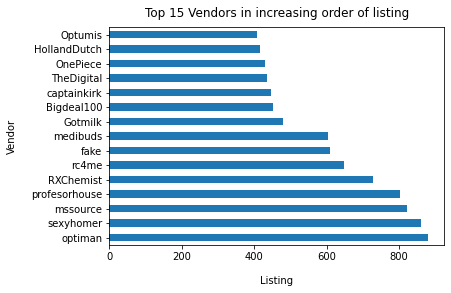

In [8]:
#Top 15 Active Vendors
top_15_vendors.plot(kind='barh')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Vendor",labelpad=14)
plt.title("Top 15 Vendors in increasing order of listing", y=1.02);

In [9]:
top_15_category = agora[' Category'].value_counts()[0:15]
top_15_category

Drugs/Cannabis/Weed              21272
Drugs/Ecstasy/Pills               7534
Drugs/Ecstasy/MDMA                6116
Drugs/Stimulants/Cocaine          6007
Drugs/Prescription                5561
Drugs/Benzos                      5393
Drugs/Cannabis/Concentrates       4257
Drugs/Psychedelics/LSD            3775
Drugs/Cannabis/Hash               3241
Drugs/Steroids                    2779
Drugs/Stimulants/Meth             2467
Drugs/Stimulants/Speed            2401
Drugs/RCs                         2182
Drugs/Stimulants/Prescription     1956
Drugs/Opioids/Heroin              1799
Name:  Category, dtype: int64

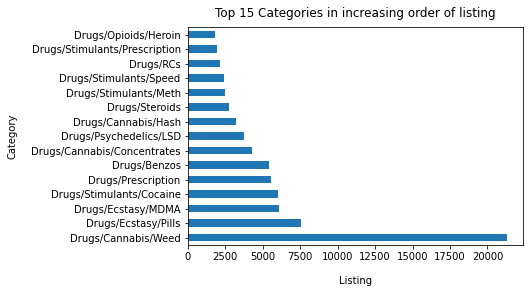

In [10]:
top_15_category.plot(kind='barh')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Category",labelpad=14)
plt.title("Top 15 Categories in increasing order of listing", y=1.02);

In [11]:
top_15_vendors.to_frame()


,Vendor
optiman,881
sexyhomer,860
mssource,823
profesorhouse,804
RXChemist,729
rc4me,648
fake,608
medibuds,604
Gotmilk,479
Bigdeal100,451


In [29]:
def LDA(data, name=""):
    # Storing the entire training text in a list
    text = list(data.values)
    # Calling our overwritten Count vectorizer
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2,
                                              stop_words='english',
                                              decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)


    lda = LatentDirichletAllocation(n_components=8, max_iter=5,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)

    lda.fit(tf)

    n_top_words = 10
    print("\n{} Topics in LDA model: ".format(name))
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
def topic_view(df, catlevel, x):
    df = df[df[" Item Description"].notnull()]
    print(LDA(df.ItemDescription[df[catlevel]==x], name=x))
    cloud(df['Item'][df[catlevel]==x].values,"Cloud for {}".format(x))

    return df.loc[df[catlevel]==x,["Item"," Item Description","Value"]].sort_values(
        by='Value',ascending=False).sample(4)

In [30]:
topic_view(df=agora, catlevel="cat1", x="Weapons")

AttributeError: 'DataFrame' object has no attribute 'ItemDescription'